In [17]:
import scipy.optimize
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy import constants as c
from astropy import units as u

In [18]:
# constants in cgs units
G = c.G.cgs.value
k = c.k_B.cgs.value
mH = c.m_p.cgs.value

yr = u.yr.to(u.s)
day = u.day.to(u.s)
hour = u.hour.to(u.s)

Rprot = 6.4e8 # cm
Mprot = 6e27 # g
T = 1e3 # K
mu = mH

cs = np.sqrt(k*T/mu)
H = Rprot**2*cs**2/G/Mprot

rs = G*Mprot/(2.*cs**2) #r_sonic

In [41]:
def fun(v, r, cs, rs):
    f = v * np.exp(-v**2/(2*cs**2)) - cs * (r/rs)**(-2) * np.exp((3/2)-(2*rs)/r)
    return f

In [42]:
r_arr = np.linspace(Rprot,5*Rprot, 100)

In [43]:
rho0 = 1e-11  # g/cm^3; initial condition density at r = Rp
rho_hydrostat = rho0*np.exp((Rprot/H)*(Rprot/r_arr-1.0))  # hydrostatic atmosphere

In [44]:
init = np.zeros(100)
init[r_arr > rs] = 2.0*cs

In [45]:
#This is the wind velocity that includes the density as rho0 at the base of the wind and that passes through 
#the sonic point (which is included using r_son)

In [46]:
fun_soln = scipy.optimize.fsolve(fun, init, args=(r_arr,cs,rs))
print (fun_soln)

[  9445.41399023  11716.36053881  14261.46327003  17071.92279957
  20135.473049    23437.18690406  26960.23661581  30686.57840406
  34597.54436474  38674.33550716  42898.41756921  47251.82648331
  51717.39343926  56278.900906    60921.18119528  65630.16857888
  70392.9149273   75197.57756106  80033.38666654  84890.59833456
  89760.43809798  94635.03880574  99507.3757858  104371.20151306
 109220.98139949 114051.83184521 118859.46131338 123640.11490293
 128390.52267322 133107.85181299 137789.66262734 142433.86823469
 147038.69780919 151602.66316941 156124.52849404 160603.28293696
 165038.1159134  169428.39483451 173773.64507646 178073.53198203
 182327.84470538 186536.48172448 190699.43785946 194816.79264842
 198888.69994541 202915.37861739 206897.10422869 210834.20161189
 214727.03823413 218576.01827666 222381.57735387 226144.17780534
 229864.3045013  233542.46110795 237179.16676477 240774.95313071
 244330.36176064 247845.94177771 251322.24781043 254759.83816701
 258159.27322182 261521.1

In [47]:
# use mass conservation to compute the density
Mdot = 4.*np.pi*Rprot**2*rho0*fun_soln[0]
density = Mdot/(4.*np.pi*r_arr**2*fun_soln) #fun_soln is wind velocity

In [48]:
def velocity_derivs(r, v, cs, Mp, G):
    rs = G*Mp/(2.*cs**2)
    if r == rs:
        dv_dr = 2.0*cs**3/G/Mp
    else:
        dv_dr = v*(2.*cs**2/r - G*Mp/r**2)/(v**2-cs**2)
    return dv_dr
#this cell just rearranges eq 2 from the homework to isolate the velocity derivative wrt r

In [49]:
from scipy.integrate import solve_ivp

In [50]:
print(r_arr[0],r_arr[-1])

6.4e+08 3200000000.0


In [51]:
len(r_arr)

100

In [52]:
v_base = 0.025*cs # a fraction of the base velocity from the previous soln
smaller_wind_sol = solve_ivp(velocity_derivs, [r_arr[0],r_arr[-1]], [v_base], t_eval=r_arr, args=(cs,Mprot,G,)) # this cell performs
#the integration, we have included interval of integration and initial conditions
v_breeze = (smaller_wind_sol['y'])[0]

# get density from Mdot
Mdot = 4.*np.pi*Rprot**2*rho0*v_breeze[0]
rho_breeze = Mdot/(4.*np.pi*r_arr**2*v_breeze) 

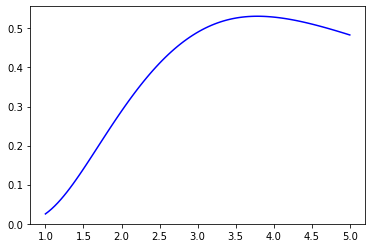

In [53]:
plt.plot(r_arr/Rprot, v_breeze/cs, 'b')

Text(0, 0.5, 'Density (g cm$^{-3}$)')

<Figure size 432x288 with 0 Axes>

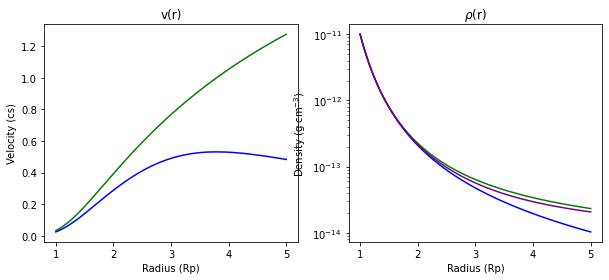

In [58]:
plt.clf()
fig, axs = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(10,4))

#vel
axs[0].plot(r_arr/Rprot, fun_soln/cs, c='green')
axs[0].plot(r_arr/Rprot, v_breeze/cs, 'b')
axs[0].set_title('v(r)')
axs[0].set_xlabel('Radius (Rp)')
axs[0].set_ylabel('Velocity (cs)')

#rho
axs[1].plot(r_arr/Rprot, rho_hydrostat, c='green')
axs[1].plot(r_arr/Rprot, density, c='blue')
axs[1].plot(r_arr/Rprot, rho_breeze, c='purple')
axs[1].set_yscale('log')
axs[1].set_title(r'$\rho$(r)')
axs[1].set_xlabel('Radius (Rp)')
axs[1].set_ylabel(r'Density (g cm$^{-3}$)')